<a href="https://colab.research.google.com/github/rininuruls/PROJECT-UAS-BIG-DATA/blob/main/classification_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, CountVectorizer, IDF,
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, sum

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace

spark = SparkSession.builder.appName("KlasifikasiBeasiswaBAZNAS").getOrCreate()

In [4]:
df = spark.read.csv("/content/Dataset_Beasiswa_BAZNAS_Indonesia.csv", header=True, inferSchema=True)


In [5]:
# Bersihkan kolom Pendapatan_Keluarga (misal: "3.000.000" jadi 3000000)
df = df.withColumn("Pendapatan_Keluarga", regexp_replace("Pendapatan_Keluarga", "[^0-9]", "").cast("int"))

# Buat label klasifikasi (multiclass)
df = df.withColumn(
    "label",
    when(
        (col("Skor_Motivasi") < 60) |
        (col("IPK") < 3.0) |
        (col("Pendapatan_Keluarga") > 5000000), 0
    ).when(
        ((col("Skor_Motivasi") >= 60) & (col("Skor_Motivasi") < 75)) |
        ((col("IPK") >= 3.0) & (col("IPK") < 3.5)) |
        ((col("Pendapatan_Keluarga") >= 3000000) & (col("Pendapatan_Keluarga") <= 5000000)), 1
    ).otherwise(2)
)

# Tambahkan label_name
df = df.withColumn(
    "label_name",
    when(col("label") == 0, "Belum Lolos")
    .when(col("label") == 1, "Lolos Bersyarat")
    .otherwise("Lolos")
)

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Gabungkan fitur numerik
assembler = VectorAssembler(
    inputCols=["Skor_Motivasi", "IPK", "Pendapatan_Keluarga"],
    outputCol="features"
)

# Model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [7]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

In [8]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi Model: {accuracy:.2f}")

Akurasi Model: 0.98


In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Akurasi Model: {accuracy:.2f}")

Akurasi Model: 0.98


In [10]:
# Tambahkan kolom label & prediksi (nama)
predictions = predictions.withColumn(
    "predicted_label_name",
    when(col("prediction") == 0, "Belum Lolos")
    .when(col("prediction") == 1, "Lolos Bersyarat")
    .otherwise("Lolos")
)

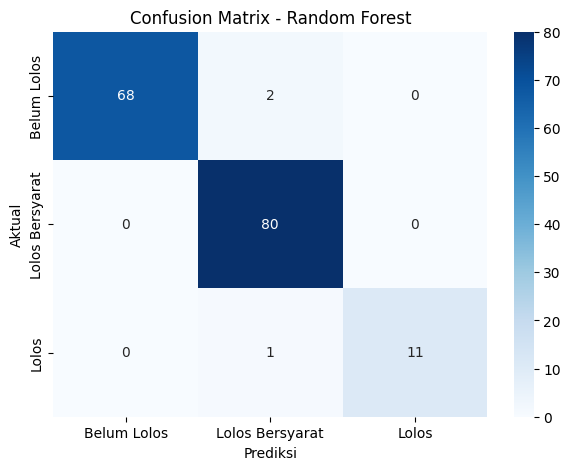

                 precision    recall  f1-score   support

    Belum Lolos       1.00      0.97      0.99        70
          Lolos       1.00      0.92      0.96        12
Lolos Bersyarat       0.96      1.00      0.98        80

       accuracy                           0.98       162
      macro avg       0.99      0.96      0.97       162
   weighted avg       0.98      0.98      0.98       162



In [11]:
# Konversi ke Pandas
pandas_df = predictions.select("label_name", "predicted_label_name").toPandas()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(pandas_df["label_name"], pandas_df["predicted_label_name"],
                      labels=["Belum Lolos", "Lolos Bersyarat", "Lolos"])

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Belum Lolos", "Lolos Bersyarat", "Lolos"],
            yticklabels=["Belum Lolos", "Lolos Bersyarat", "Lolos"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Laporan
print(classification_report(pandas_df["label_name"], pandas_df["predicted_label_name"]))

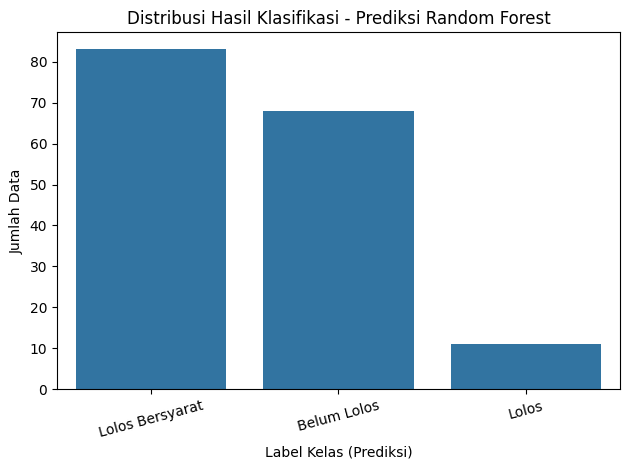

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi distribusi hasil klasifikasi
sns.countplot(x="predicted_label_name", data=pandas_df, order=pandas_df["predicted_label_name"].value_counts().index)

plt.title("Distribusi Hasil Klasifikasi - Prediksi Random Forest")
plt.xlabel("Label Kelas (Prediksi)")
plt.ylabel("Jumlah Data")
plt.xticks(rotation=15)  # Jika label panjang, bisa diputar
plt.tight_layout()
plt.show()